In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv(r"C:\Users\fatma\Downloads\data.csv")

In [3]:
import pandas as pd

# Assuming your dataframe is named 'df' and it has columns 'ORDER_ID' and 'CATEGORY'

# Step 1: Group by ORDER_ID and aggregate categories
grouped = df.groupby('ORDER_ID')['Category'].unique().reset_index()

# Step 2: Convert array of unique categories to comma-separated string
grouped['Unique_Categories'] = grouped['Category'].apply(lambda x: ', '.join(sorted(x)))

# Step 3: Drop the 'CATEGORY' column if you no longer need it
grouped.drop(columns=['Category'], inplace=True)

# Merge the unique categories back to the original dataframe based on ORDER_ID
df = pd.merge(df, grouped, on='ORDER_ID', how='left')

In [4]:
filtered_df = pd.read_csv(r"C:\Users\fatma\Desktop\final.csv", sep=';')

In [5]:
filtered_df1 = df[df['ORDER_ID'].isin(filtered_df['ORDER_ID'])]

In [6]:
df['CAMPAIGN'] = df['CAMPAIGN'].fillna('Other')
df['DATE'] = pd.to_datetime(df['DATE'])

In [7]:
filtered_df['Basket Revenue'] = filtered_df['Basket Revenue'].str.replace(',', '.').astype(float)

In [8]:
df_left_joined = pd.merge(filtered_df1, filtered_df[['Basket Revenue','ORDER_ID']], on='ORDER_ID', how='left')

In [9]:
df_left_joined.describe()

,CARGO_ID,ORDER_ID,SUB_CATEGORY_CODE,QTY,DESI,Total_Price,Unit_Price,Revenue,Unit_SHF,Real_SHC,Basket Revenue
count,3.263200e+05,3.263200e+05,3.263200e+05,326320.000000,326320.000000,326320.000000,326320.000000,326320.000000,326320.000000,326320.000000,326320.000000
mean,1.225276e+06,8.209845e+07,2.034830e+04,1.446715,4.163701,205.189388,202.886299,231.240752,2.303090,3.186202,368.052055
std,7.042840e+05,2.396630e+07,1.206385e+06,3.523313,5.902089,518.095102,516.718828,801.406292,4.001711,4.292301,1259.168718
min,6.000000e+00,1.000049e+07,1.300000e+01,1.000000,0.010000,0.160000,0.160000,1.010000,0.000000,0.007086,1.020000
25%,6.186368e+05,7.999021e+07,5.290000e+02,1.000000,1.000000,15.780000,13.980000,18.430000,0.000000,1.281506,60.920000
50%,1.226392e+06,9.299426e+07,3.045000e+03,1.000000,2.000000,35.020000,33.810000,42.400000,0.000000,2.390622,115.410000
75%,1.834700e+06,9.650024e+07,3.463000e+03,1.000000,5.000000,75.042500,71.950000,101.640000,3.940000,3.733110,219.600000
max,2.444520e+06,9.999998e+07,8.012203e+07,998.000000,170.000000,20592.370000,20592.370000,168331.780000,98.050000,908.399330,175596.480000


In [10]:
def create_near_100_feature(df, column_name='Revenue', bandwidth=2):
    near_100_column = f'Near_{100-bandwidth}_to_{100+bandwidth}'
    df[near_100_column] = ((df[column_name] >= (100 - bandwidth)) & 
                            (df[column_name] <= (100 + bandwidth))).astype(int)
    return df

# Now we'll use our function to add the 'Near_100' feature to this dataframe.
df_left_joined = create_near_100_feature(df_left_joined)

In [11]:
def enhance_data_with_shipping_info(df, threshold=100):
    
    # Absolute distance from the threshold
    df['Distance_From_Threshold'] = abs(df['Revenue'] - threshold)
    
    # Proximity to threshold: Below, At, or Above
    df['Proximity_To_Threshold'] = pd.cut(df['Revenue'],
                                          bins=[-np.inf, threshold - 1, threshold, np.inf],
                                          labels=['Below_Threshold', 'At_Threshold', 'Above_Threshold'])

    return df

df_left_joined = enhance_data_with_shipping_info(df_left_joined)

In [12]:
def create_sliding_window_features(df, column, windows):
    for window in windows:
        # Create a new column name for the window
        window_col_name = f"{column}_{window[0]}_to_{window[1]}"
        # Create a binary feature where 1 indicates the value falls within the current window
        df[window_col_name] = df[column].apply(lambda x: 1 if window[0] <= x < window[1] else 0)
    
    return df

# Define your price range windows
price_windows = [(60, 80), (80, 100), (100, 120), (120, 140)]

# Apply the function to your dataframe
# This assumes 'df' is the DataFrame and 'Basket_Revenue' is the column we're interested in.
# Replace 'df' and 'Basket_Revenue' with your actual DataFrame and column name.
df_left_joined = create_sliding_window_features(df_left_joined, 'Basket Revenue', price_windows)

In [13]:
def filter_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        if column == 'Basket Revenue':
            upper_bound = 4000
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df
df_left_joined = filter_outliers(df_left_joined, ['Basket Revenue', 'Unit_SHF', 'Real_SHC', 'DESI', 'QTY', 'Unit_Price',])

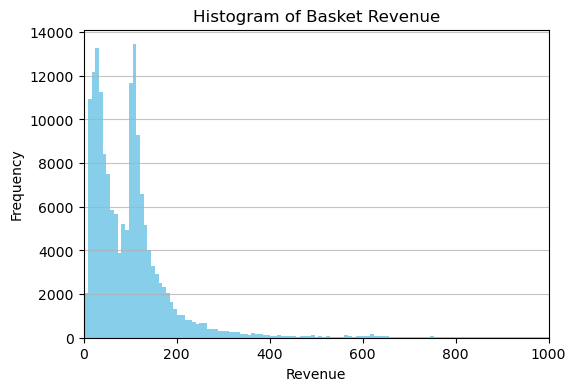

In [14]:
plt.figure(figsize=(6, 4))
plt.hist(df_left_joined['Basket Revenue'], bins=500,color='skyblue')
plt.title('Histogram of Basket Revenue')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0,1000)
plt.show()

In [15]:
columns_to_remove = ['CARGO_ID', 'SUB_CATEGORY_CODE', 
                     'SKU', 'SHIPPING_COMPANY', 'PRODUCT_NAME', 'Revenue','DATE','QTY','Total_Price', 'ORDER_ID','SUB_CATEGORY']
new_df = df_left_joined.drop(columns=columns_to_remove)

In [16]:
df_encoded = pd.get_dummies(new_df, columns=['Weekend', 'Seller','FreeSH', 'CFreeSH','CAMPAIGN', 'Category','Unique_Categories','Proximity_To_Threshold'])

In [17]:
# Columns to scale
columns_to_scale = ['DESI','Unit_Price','Unit_SHF', 'Real_SHC', 'Distance_From_Threshold']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the specified columns
df_encoded[columns_to_scale] = scaler.fit_transform(df_encoded[columns_to_scale])

In [18]:
df_encoded.head()

,DESI,Unit_Price,Unit_SHF,Real_SHC,Basket Revenue,Near_98_to_102,Distance_From_Threshold,Basket Revenue_60_to_80,Basket Revenue_80_to_100,Basket Revenue_100_to_120,...,Unique_Categories_PET,"Unique_Categories_PET, TEL1","Unique_Categories_PET, TEL1, TEL2","Unique_Categories_PET, TEL2",Unique_Categories_TEL1,"Unique_Categories_TEL1, TEL2",Unique_Categories_TEL2,Proximity_To_Threshold_Below_Threshold,Proximity_To_Threshold_At_Threshold,Proximity_To_Threshold_Above_Threshold
1,0.101643,0.015172,0.523858,0.323185,8.12,0,0.928175,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,0.204312,0.511943,0.000000,0.829076,109.96,0,0.335286,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0.717659,0.327861,0.000000,0.944877,109.96,0,0.574300,0,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0.101643,0.084416,0.523858,0.279655,17.02,0,0.838266,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0.101643,0.084416,0.000000,0.394094,11.86,0,0.890393,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [19]:
from sklearn.model_selection import StratifiedShuffleSplit

# Assuming 'df' is your DataFrame and 'continuous_feature' is the name of your continuous column.
# Replace these with your actual DataFrame and column names.
df.reset_index(drop=True, inplace=True)

# Bin the continuous feature into quartiles or another number of bins that makes sense for your data
df_encoded['feature_bins'] = pd.qcut(df_encoded['Unit_Price'], q=10, duplicates='drop')
# Initialize StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Perform the split
for train_index, test_index in sss.split(df_encoded, df_encoded['feature_bins']):
    X_train = df_encoded.iloc[train_index].drop(['Basket Revenue', 'feature_bins'], axis=1)
    X_test = df_encoded.iloc[test_index].drop(['Basket Revenue', 'feature_bins'], axis=1)
    y_train = df_encoded.iloc[train_index]['Basket Revenue']
    y_test = df_encoded.iloc[test_index]['Basket Revenue']

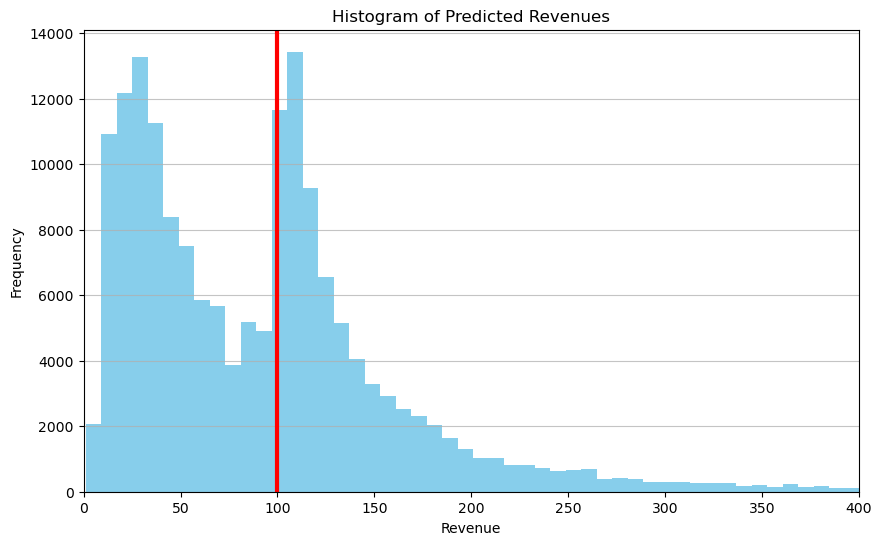

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(df_encoded['Basket Revenue'], bins=500, color='skyblue')
plt.axvline(100, color='red', linewidth=3)
plt.title('Histogram of Predicted Revenues')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0,400)
plt.show()

In [49]:
from catboost import CatBoostRegressor
# Define the CatBoost regressor
reg = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=6, loss_function='RMSE')

# Train the regressor
reg.fit(X_train, y_train, verbose=10)
y_train_pred = reg.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
print("Mean Squared Error on Training Set:", train_mse)

# Make predictions on the testing set
y_pred = reg.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

0:	learn: 327.8331934	total: 178ms	remaining: 17.6s
10:	learn: 228.6853956	total: 283ms	remaining: 2.29s
20:	learn: 208.7885017	total: 373ms	remaining: 1.4s
30:	learn: 203.6724427	total: 472ms	remaining: 1.05s
40:	learn: 201.4003361	total: 561ms	remaining: 807ms
50:	learn: 199.7253398	total: 648ms	remaining: 622ms
60:	learn: 198.7987313	total: 737ms	remaining: 471ms
70:	learn: 197.9267078	total: 829ms	remaining: 338ms
80:	learn: 196.9203487	total: 921ms	remaining: 216ms
90:	learn: 196.2812187	total: 1.01s	remaining: 99.9ms
99:	learn: 195.5697394	total: 1.11s	remaining: 0us
Mean Squared Error on Training Set: 38247.52289155118


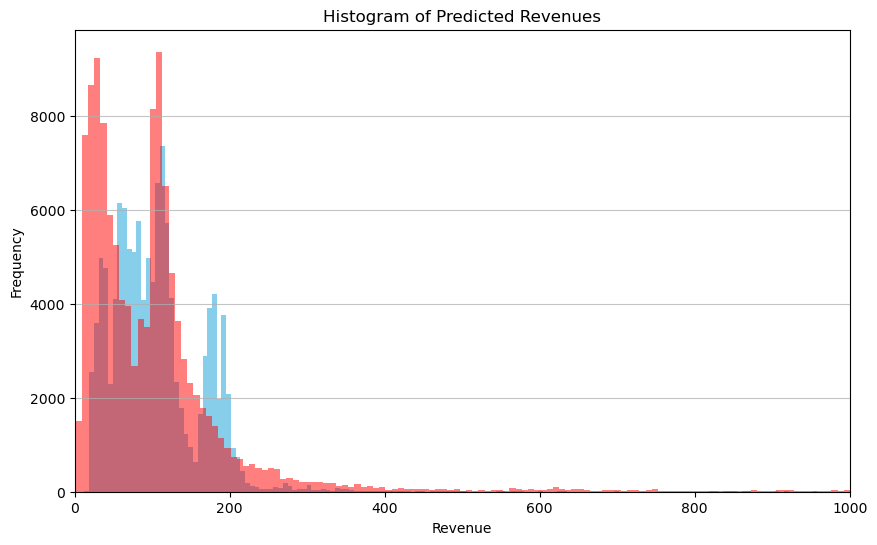

In [53]:
plt.figure(figsize=(10, 6))
plt.hist(y_train_pred, bins=500, color='skyblue')
plt.hist(y_train, bins=500, color='red', alpha=0.5, label='Actual')
plt.title('Histogram of Predicted Revenues')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0,1000)
plt.show()

In [26]:
# Initialize the model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate MSE for training and testing data
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print("Training MSE:", mse_train)
print("Testing MSE:", mse_test)

# Calculate R^2 for training and testing data
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Training R^2:", r2_train)
print("Testing R^2:", r2_test)


Training MSE: 47153.26178272328
Testing MSE: 48589.23972368594
Training R^2: 0.6124643481640468
Testing R^2: 0.6065496441235101


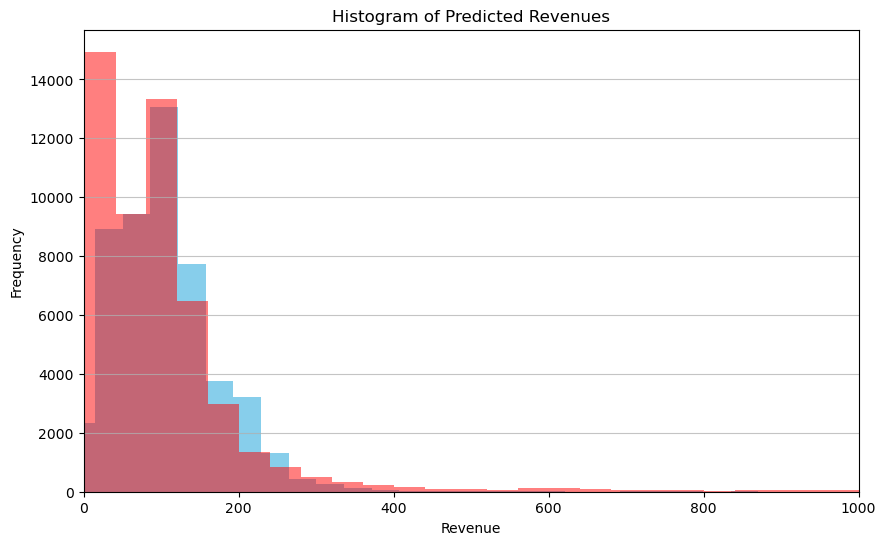

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(y_test_pred, bins=100, color='skyblue')
plt.hist(y_test, bins=100, color='red', alpha=0.5, label='Actual')
plt.title('Histogram of Predicted Revenues')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0,1000)
plt.show()

In [30]:
from sklearn.linear_model import Ridge

# Initialize Ridge regression model with regularization parameter alpha
ridge_model = Ridge(alpha=0.01)

# Fit the Ridge model on the training data
ridge_model.fit(X_train, y_train)

# Make predictions on training and testing data
y_train_pred_ridge = ridge_model.predict(X_train)
y_test_pred_ridge = ridge_model.predict(X_test)

# Calculate MSE and R^2 for training and testing data with Ridge regression
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
mse_test_ridge = mean_squared_error(y_test, y_test_pred_ridge)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)
r2_test_ridge = r2_score(y_test, y_test_pred_ridge)

print("Ridge Regression:")
print("Training MSE:", mse_train_ridge)
print("Testing MSE:", mse_test_ridge)
print("Training R^2:", r2_train_ridge)
print("Testing R^2:", r2_test_ridge)


Ridge Regression:
Training MSE: 47153.29749479797
Testing MSE: 48589.20761498149
Training R^2: 0.6124640546593854
Testing R^2: 0.6065499041230751


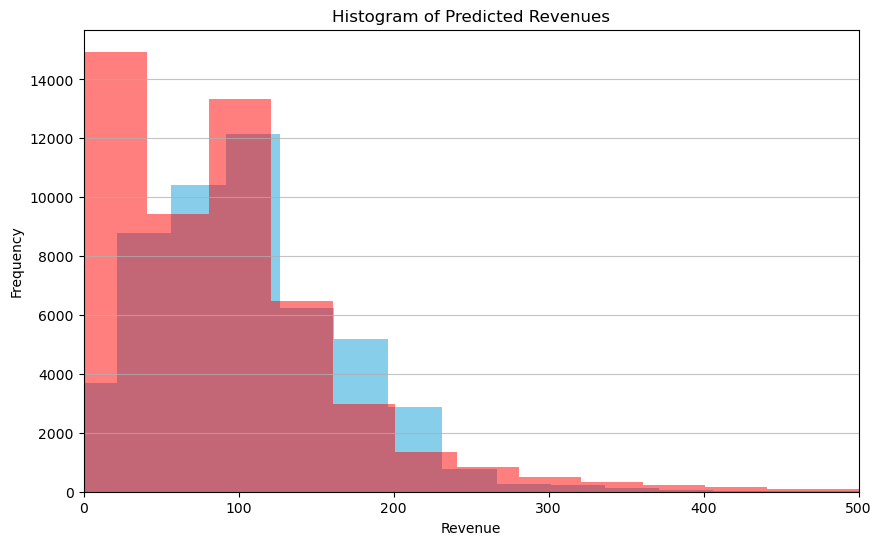

In [46]:
plt.figure(figsize=(10, 6))
plt.hist(y_test_pred_ridge, bins=100, color='skyblue')
plt.hist(y_test, bins=100, color='red', alpha=0.5, label='Actual')
plt.title('Histogram of Predicted Revenues')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0,500)
plt.show()

In [43]:
import xgboost as xgb

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', 
                              colsample_bytree = 0.9, 
                              learning_rate = 0.1,
                              max_depth = 5, 
                              alpha = 100, 
                              n_estimators = 500)

# Fit the XGBoost model on the training data
xgb_model.fit(X_train, y_train)

# Make predictions on training and testing data
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

# Calculate MSE and R^2 for training and testing data with XGBoost
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print("XGBoost Regression:")
print("Training MSE:", mse_train_xgb)
print("Testing MSE:", mse_test_xgb)
print("Training R^2:", r2_train_xgb)
print("Testing R^2:", r2_test_xgb)

XGBoost Regression:
Training MSE: 28818.43851607709
Testing MSE: 35937.84975721859
Training R^2: 0.7631516477760562
Testing R^2: 0.7089940106735045


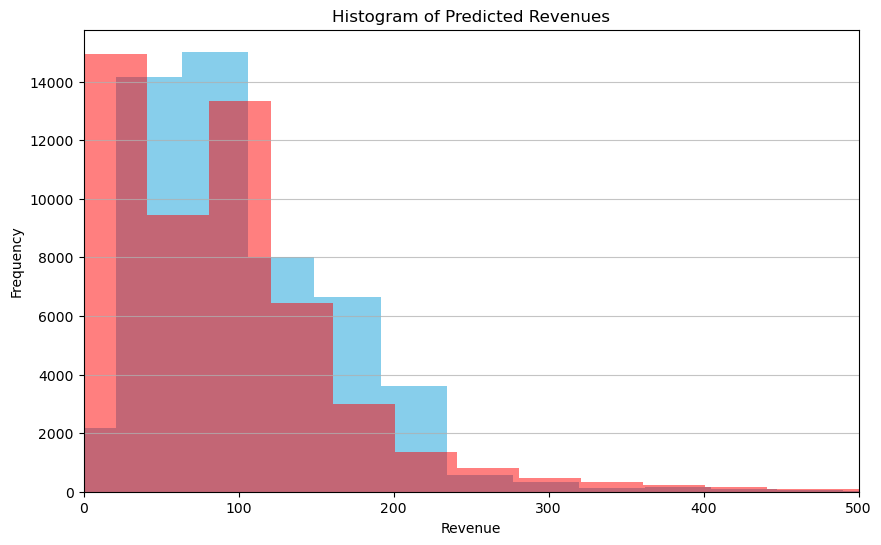

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(y_test_pred_xgb, bins=100, color='skyblue')
plt.hist(y_test, bins=100, color='red', alpha=0.5, label='Actual')
plt.title('Histogram of Predicted Revenues')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0,500)
plt.show()

In [31]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Initialize Support Vector Regressor
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the SVR model on the training data (using the same training data from XGBoost example)
svr_model.fit(X_train, y_train)

# Make predictions on training and testing data
y_train_pred_svr = svr_model.predict(X_train)
y_test_pred_svr = svr_model.predict(X_test)

# Calculate MSE and R^2 for training and testing data with SVR
mse_train_svr = mean_squared_error(y_train, y_train_pred_svr)
mse_test_svr = mean_squared_error(y_test, y_test_pred_svr)
r2_train_svr = r2_score(y_train, y_train_pred_svr)
r2_test_svr = r2_score(y_test, y_test_pred_svr)

print("Support Vector Regression:")
print("Training MSE:", mse_train_svr)
print("Testing MSE:", mse_test_svr)
print("Training R^2:", r2_train_svr)
print("Testing R^2:", r2_test_svr)

Support Vector Regression:
Training MSE: 73461.49819783808
Testing MSE: 75202.11256526102
Training R^2: 0.3962464416538888
Testing R^2: 0.39105246100316515
